In [1]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import sys

sys.path.append("..")

from tensorflow import keras
from keras import optimizers, models

import matplotlib.pyplot as plt
from matplotlib import colors

import pandas as pd
import geopandas as gpd
from pyproj import CRS

import numpy as np
from tqdm.notebook import tqdm
import rasterio

from src.data_utils import combine_wealth_dfs
from src.data_utils import get_label_for_img
from src.data_utils import create_splits

crs = CRS("EPSG:4326")

# Import Data

## Satellite Images

In [3]:
viirs_s2_path = '/mnt/datadisk/data/VIIRS_Sentinel2/asset/urban/all/'
viirs_path = '/mnt/datadisk/data/VIIRS/preprocessed/asset/rural//all/'

In [4]:
all_urban_data = os.listdir(viirs_s2_path)
len(all_urban_data)

2458

In [5]:
all_rural_data = os.listdir(viirs_path)
len(all_rural_data)

5602

## Geographic Information

In [6]:
countries = list(set([x.split('_')[3] for x in all_urban_data]))
countries

['UGA', 'COD', 'MOZ', 'MWI', 'ETH', 'ZMB', 'KEN', 'TZA', 'RWA', 'ZWE']

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries_gdf = world[world.iso_a3.isin(countries)]
countries_gdf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
11,83301151,Africa,Dem. Rep. Congo,COD,66010.0,"POLYGON ((29.34000 -4.49998, 29.51999 -5.41998..."
13,47615739,Africa,Kenya,KEN,152700.0,"POLYGON ((39.20222 -4.67677, 37.76690 -3.67712..."
48,13805084,Africa,Zimbabwe,ZWE,28330.0,"POLYGON ((31.19141 -22.25151, 30.65987 -22.151..."
70,15972000,Africa,Zambia,ZMB,65170.0,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458..."
71,19196246,Africa,Malawi,MWI,21200.0,"POLYGON ((32.75938 -9.23060, 33.73972 -9.41715..."
72,26573706,Africa,Mozambique,MOZ,35010.0,"POLYGON ((34.55999 -11.52002, 35.31240 -11.439..."
165,105350020,Africa,Ethiopia,ETH,174700.0,"POLYGON ((47.78942 8.00300, 44.96360 5.00162, ..."
168,39570125,Africa,Uganda,UGA,84930.0,"POLYGON ((33.90371 -0.95000, 31.86617 -1.02736..."
169,11901484,Africa,Rwanda,RWA,21970.0,"POLYGON ((30.41910 -1.13466, 30.81613 -1.69891..."


## Urban Data

In [8]:
X_train_val, X_test, y_train_val, y_test = create_splits(img_dir='/mnt/datadisk/data/VIIRS_Sentinel2/asset/urban/all/', wealth_path='/home/stoermer/Sentinel/gps_csv/', urban_rural='u', pre2015_path=False)

Gathering Label Data


100%|███████████████████████████████████████████████████████████████████████████████| 2458/2458 [01:03<00:00, 38.76it/s]


In [9]:
wealth_df = combine_wealth_dfs('/home/stoermer/Sentinel/gps_csv/')

urban_test_labels = pd.DataFrame()
for x in tqdm(X_test):
    urban_test_labels = pd.concat([urban_test_labels, get_label_for_img(wealth_df, x)])
urban_test_labels

  0%|          | 0/492 [00:00<?, ?it/s]

,WEALTH_INDEX,SURVEY_YEAR,LATNUM,LONGNUM
0,1.071443,2015,-17.9025,30.6523
0,-0.068987,2014,-9.8081,29.0395
0,2.655006,2013,-4.3835,15.3125
0,1.668783,2019,2.7515,32.2981
0,1.278176,2015,-20.1791,28.6178
...,...,...,...,...
0,0.780936,2016,13.3427,39.7597
0,0.980313,2016,-5.7441,34.8325
0,0.135483,2019,-2.7007,29.0006
0,2.779817,2018,-25.8828,32.5081


### Get Predictions of Best Model

In [10]:
model = keras.models.load_model('./vgg19_viirs_s2_u.h5')

In [11]:
data_urban = np.zeros(shape=(len(X_test), 14, 200, 200))
for index, img in tqdm(enumerate(X_test)):
    # Read in each Image
    with rasterio.open(os.path.join(viirs_s2_path, img)) as i:
        array = i.read().astype("float32")

    # Ensure that the Array is not empty
    array[np.isnan(array)] = 0
    assert not np.any(np.isnan(array)), "Float"

    # Add to batch
    data_urban[index] = array

    # Check if batch is already full (Note: Index in batch array is from 0...4 hence we need to add +1 to batch_ele)
data_urban = data_urban.transpose(0, 2, 3, 1)
preds_urban = model.predict(data_urban)
len(preds_urban)

0it [00:00, ?it/s]

492

### Create Geo DataFrames for Groundtruth and Predictions

In [12]:
geometry = gpd.points_from_xy(urban_test_labels.LONGNUM, urban_test_labels.LATNUM)

true_urban_wealth_df = gpd.GeoDataFrame(urban_test_labels,
                       geometry=geometry,
                       crs=crs
                      )
true_urban_wealth_df['COUNTRY_CODE'] = [x.split('_')[3] for x in X_test]
true_urban_wealth_df = true_urban_wealth_df[['SURVEY_YEAR', 'geometry','COUNTRY_CODE','WEALTH_INDEX']]
true_urban_wealth_df.head(3)

,SURVEY_YEAR,geometry,COUNTRY_CODE,WEALTH_INDEX
0,2015,POINT (30.65230 -17.90250),ZWE,1.071443
0,2014,POINT (29.03950 -9.80810),ZMB,-0.068987
0,2013,POINT (15.31250 -4.38350),COD,2.655006


In [13]:
predicted_urban_wealth_df = true_urban_wealth_df.loc[:,['SURVEY_YEAR', 'geometry']]
predicted_urban_wealth_df['WEALTH_INDEX'] = preds_urban
predicted_urban_wealth_df

,SURVEY_YEAR,geometry,WEALTH_INDEX
0,2015,POINT (30.65230 -17.90250),1.538016
0,2014,POINT (29.03950 -9.80810),0.407157
0,2013,POINT (15.31250 -4.38350),2.204992
0,2019,POINT (32.29810 2.75150),1.057997
0,2015,POINT (28.61780 -20.17910),0.996908
...,...,...,...
0,2016,POINT (39.75970 13.34270),0.425004
0,2016,POINT (34.83250 -5.74410),1.155177
0,2019,POINT (29.00060 -2.70070),0.764184
0,2018,POINT (32.50810 -25.88280),1.686300


In [14]:
crs = CRS("EPSG:4326")
predicted_urban_wealth_df = gpd.GeoDataFrame(predicted_urban_wealth_df,
                                             geometry=predicted_urban_wealth_df['geometry'],
                                             crs=crs)
true_urban_wealth_df = gpd.GeoDataFrame(true_urban_wealth_df,
                                             geometry=true_urban_wealth_df['geometry'],
                                             crs=crs)

### Plot Predictions vs. Groundtruth

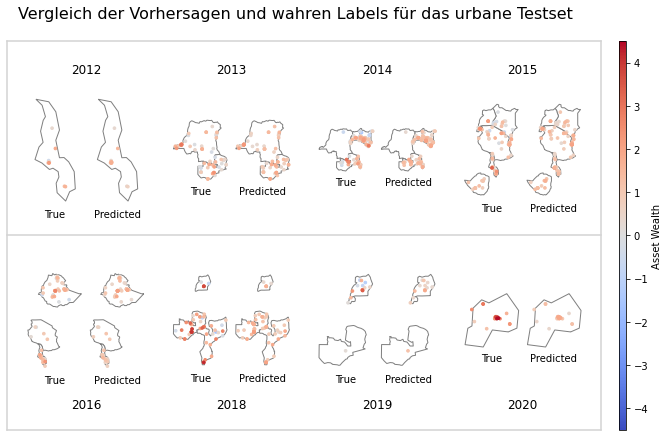

In [15]:
divnorm=colors.TwoSlopeNorm(vmin=-4.5, vcenter=0., vmax=4.5)
# plt.subplots_adjust(wspace=None, hspace=None)
markersize=7
predicted_countries_gdf = countries_gdf[countries_gdf.iso_a3.isin(true_urban_wealth_df.COUNTRY_CODE)]

mosaic =  [['title_2012','title_2012','title_2012','title_2012','title_2012','title_2012','.',
            'title_2013','title_2013','title_2013','title_2013','title_2013','title_2013','.',
            'title_2014','title_2014','title_2014','title_2014','title_2014','title_2014','.',
            'title_2015','title_2015','title_2015','title_2015','title_2015','title_2015'],
        ['true2012','true2012','true2012','pred2012','pred2012','pred2012','.', 
            'true2013', 'true2013','true2013','pred2013','pred2013','pred2013', '.',
            'true2014','true2014','true2014','pred2014','pred2014','pred2014','.',
        'true2015','true2015','true2015','pred2015','pred2015','pred2015'],
           ['title_2016','title_2016','title_2016','title_2016','title_2016','title_2016','.',
            'title_2018','title_2018','title_2018','title_2018','title_2018','title_2018','.',
            'title_2019','title_2019','title_2019','title_2019','title_2019','title_2019','.',
            'title_2020','title_2020','title_2020','title_2020','title_2020','title_2020'],
           ['true2016','true2016','true2016','pred2016','pred2016','pred2016', '.', 
            'true2018','true2018','true2018', 'pred2018', 'pred2018','pred2018','.',
            'true2019','true2019','true2019','pred2019','pred2019','pred2019','.', 
            'true2020', 'true2020', 'true2020','pred2020','pred2020','pred2020'],
]
    
fig, axes = plt.subplot_mosaic(mosaic,figsize=(10,6), gridspec_kw=(dict(height_ratios=(.8,3,.8,3))))#, constrained_layout=True)
fig.suptitle('Vergleich der Vorhersagen und wahren Labels für das urbane Testset',fontsize=16)

for index, row in enumerate(mosaic):
    row = [k for k in row if k!='.']
    keys=[]
    for k in row:
        if k not in keys:
            keys.append(k)
#     print(keys)
    for k in keys:
        predicted_countries_gdf = countries_gdf[countries_gdf.iso_a3.isin(true_urban_wealth_df[true_urban_wealth_df.SURVEY_YEAR==int(k[-4:])].COUNTRY_CODE)]
        if k.startswith('title'):
            if index==0:
                axes[k].set_title(k[-4:], fontsize=12,y=0)
            else:
                axes[k].set_title(k[-4:], fontsize=12,y=-5.5)
        elif k.startswith('true'):
            predicted_countries_gdf.plot(ax=axes[k], color='white', edgecolor='grey')
            true_urban_wealth_df[true_urban_wealth_df.SURVEY_YEAR==int(k[-4:])].sort_values(by='WEALTH_INDEX').plot(ax = axes[k], column='WEALTH_INDEX', cmap='coolwarm',norm=divnorm, markersize=markersize)
            axes[k].set_xlabel('True')
        else:
            predicted_countries_gdf.plot(ax=axes[k], color='white', edgecolor='grey')
            predicted_urban_wealth_df[predicted_urban_wealth_df.SURVEY_YEAR==int(k[-4:])].sort_values(by='WEALTH_INDEX').plot(ax = axes[k], column='WEALTH_INDEX', cmap='coolwarm',norm=divnorm, markersize=markersize)
            axes[k].set_xlabel('Predicted')
        axes[k].spines['top'].set_visible(False)
        axes[k].spines['right'].set_visible(False)
        axes[k].spines['bottom'].set_visible(False)
        axes[k].spines['left'].set_visible(False)
        axes[k].get_xaxis().set_ticks([])
        axes[k].get_yaxis().set_ticks([])

line = plt.Line2D([0.1,.925],[.45,.45], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([0.1,.925],[0,0], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([0.1,.925],[.9,.9], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([0.1,0.1],[0,.9], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([.925,.925],[0,.9], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-4.5, vmax=4.5), cmap='coolwarm')
cbaxes = fig.add_axes([0.95, 0,  0.01, 0.9])
cbar = fig.colorbar(sm, orientation='vertical',label='Asset Wealth',cax=cbaxes)

plt.show()

## Rural Data
### Get Label Data

In [16]:
wealth_df = combine_wealth_dfs('/home/stoermer/Sentinel/gps_csv/')

In [17]:
X_train_val, X_test, y_train_val, y_test = create_splits(img_dir='/mnt/datadisk/data/VIIRS/preprocessed/asset/rural/all/', wealth_path='/home/stoermer/Sentinel/gps_csv/', urban_rural='r', pre2015_path=False)

Gathering Label Data


100%|███████████████████████████████████████████████████████████████████████████████| 5602/5602 [02:25<00:00, 38.55it/s]


In [18]:
rural_test_labels = pd.DataFrame()
for x in tqdm(X_test):
    rural_test_labels = pd.concat([rural_test_labels, get_label_for_img(wealth_df, x)])
rural_test_labels

  0%|          | 0/1121 [00:00<?, ?it/s]

,WEALTH_INDEX,SURVEY_YEAR,LATNUM,LONGNUM
0,-0.688140,2015,-17.7214,31.7259
0,-0.216390,2014,-0.6815,35.2460
0,-0.112214,2016,7.2301,35.3157
0,-0.212770,2015,-12.9103,34.2767
0,-0.168055,2016,-8.4875,39.2632
...,...,...,...,...
0,-0.734604,2014,1.9172,33.6136
0,-0.500560,2015,-1.7555,29.6134
0,-0.504263,2015,-16.4775,30.4724
0,-0.375565,2014,0.0005,37.9925


### Get Predictions of Best Model

In [19]:
model = keras.models.load_model('./resnet50_r_viirs.h5')

In [20]:
data_rural = np.zeros(shape=(len(X_test), 3, 1000, 1000))
for index, img in tqdm(enumerate(X_test)):
    # Read in each Image
    with rasterio.open(os.path.join(viirs_path, img)) as i:
        array = i.read().astype("float32")

    # Ensure that the Array is not empty
    array[np.isnan(array)] = 0
    assert not np.any(np.isnan(array)), "Float"

    # Add to batch
    data_rural[index] = array

    # Check if batch is already full (Note: Index in batch array is from 0...4 hence we need to add +1 to batch_ele)
data_rural = data_rural.transpose(0, 2, 3, 1)
preds_rural = model.predict(data_rural)
len(preds_rural)

0it [00:00, ?it/s]

1121

### Create Geo DataFrames for Groundtruth and Predictions

In [21]:
crs = CRS("EPSG:4326")
geometry = gpd.points_from_xy(rural_test_labels.LONGNUM, rural_test_labels.LATNUM)

true_rural_wealth_df = gpd.GeoDataFrame(rural_test_labels,
                       geometry=geometry,
                       crs=crs
                      )
true_rural_wealth_df['COUNTRY_CODE'] = [x.split('_')[3] for x in X_test]
true_rural_wealth_df = true_rural_wealth_df[['SURVEY_YEAR', 'geometry', 'COUNTRY_CODE','WEALTH_INDEX']]
true_rural_wealth_df.head(3)

,SURVEY_YEAR,geometry,COUNTRY_CODE,WEALTH_INDEX
0,2015,POINT (31.72590 -17.72140),ZWE,-0.688140
0,2014,POINT (35.24600 -0.68150),KEN,-0.216390
0,2016,POINT (35.31570 7.23010),ETH,-0.112214


In [22]:
predicted_rural_wealth_df = true_rural_wealth_df.loc[:,['SURVEY_YEAR', 'geometry', 'COUNTRY_CODE']]
predicted_rural_wealth_df['WEALTH_INDEX'] = preds_rural
predicted_rural_wealth_df.head(3)

,SURVEY_YEAR,geometry,COUNTRY_CODE,WEALTH_INDEX
0,2015,POINT (31.72590 -17.72140),ZWE,-0.548155
0,2014,POINT (35.24600 -0.68150),KEN,-0.588530
0,2016,POINT (35.31570 7.23010),ETH,-0.588530


### Plot Predictions vs. Groundtruth

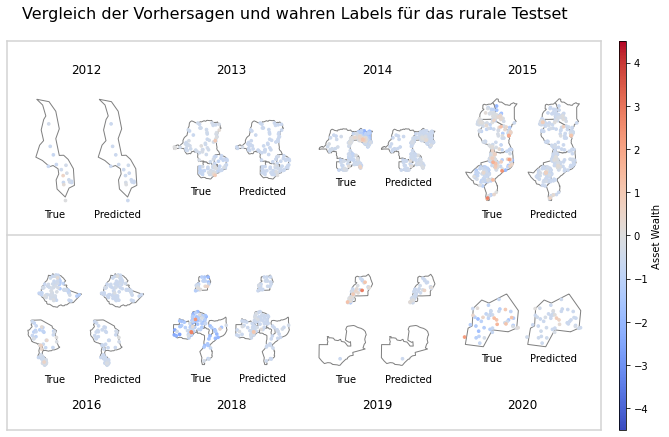

In [23]:
divnorm=colors.TwoSlopeNorm(vmin=-4.5, vcenter=0., vmax=4.5)
# plt.subplots_adjust(wspace=None, hspace=None)
markersize=7
predicted_countries_gdf = countries_gdf[countries_gdf.iso_a3.isin(true_rural_wealth_df.COUNTRY_CODE)]

mosaic =  [['title_2012','title_2012','title_2012','title_2012','title_2012','title_2012','.',
            'title_2013','title_2013','title_2013','title_2013','title_2013','title_2013','.',
            'title_2014','title_2014','title_2014','title_2014','title_2014','title_2014','.',
            'title_2015','title_2015','title_2015','title_2015','title_2015','title_2015'],
        ['true2012','true2012','true2012','pred2012','pred2012','pred2012','.', 
            'true2013', 'true2013','true2013','pred2013','pred2013','pred2013', '.',
            'true2014','true2014','true2014','pred2014','pred2014','pred2014','.',
        'true2015','true2015','true2015','pred2015','pred2015','pred2015'],
           ['title_2016','title_2016','title_2016','title_2016','title_2016','title_2016','.',
            'title_2018','title_2018','title_2018','title_2018','title_2018','title_2018','.',
            'title_2019','title_2019','title_2019','title_2019','title_2019','title_2019','.',
            'title_2020','title_2020','title_2020','title_2020','title_2020','title_2020'],
           ['true2016','true2016','true2016','pred2016','pred2016','pred2016', '.', 
            'true2018','true2018','true2018', 'pred2018', 'pred2018','pred2018','.',
            'true2019','true2019','true2019','pred2019','pred2019','pred2019','.', 
            'true2020', 'true2020', 'true2020','pred2020','pred2020','pred2020'],
]
    
fig, axes = plt.subplot_mosaic(mosaic,figsize=(10,6), gridspec_kw=(dict(height_ratios=(.8,3,.8,3))))#, constrained_layout=True)
fig.suptitle('Vergleich der Vorhersagen und wahren Labels für das rurale Testset',fontsize=16)

for index, row in enumerate(mosaic):
    row = [k for k in row if k!='.']
    keys=[]
    for k in row:
        if k not in keys:
            keys.append(k)
#     print(keys)
    for k in keys:
        predicted_countries_gdf = countries_gdf[countries_gdf.iso_a3.isin(true_rural_wealth_df[true_rural_wealth_df.SURVEY_YEAR==int(k[-4:])].COUNTRY_CODE)]
        if k.startswith('title'):
            if index==0:
                axes[k].set_title(k[-4:], fontsize=12,y=0)
            else:
                axes[k].set_title(k[-4:], fontsize=12,y=-5.5)
        elif k.startswith('true'):
            predicted_countries_gdf.plot(ax=axes[k], color='white', edgecolor='grey')
            true_rural_wealth_df[true_rural_wealth_df.SURVEY_YEAR==int(k[-4:])].sort_values(by='WEALTH_INDEX').plot(ax = axes[k], column='WEALTH_INDEX', cmap='coolwarm',norm=divnorm, markersize=markersize)
            axes[k].set_xlabel('True')
        else:
            predicted_countries_gdf.plot(ax=axes[k], color='white', edgecolor='grey')
            predicted_rural_wealth_df[predicted_rural_wealth_df.SURVEY_YEAR==int(k[-4:])].sort_values(by='WEALTH_INDEX').plot(ax = axes[k], column='WEALTH_INDEX', cmap='coolwarm',norm=divnorm, markersize=markersize)
            axes[k].set_xlabel('Predicted')
        axes[k].spines['top'].set_visible(False)
        axes[k].spines['right'].set_visible(False)
        axes[k].spines['bottom'].set_visible(False)
        axes[k].spines['left'].set_visible(False)
        axes[k].get_xaxis().set_ticks([])
        axes[k].get_yaxis().set_ticks([])

line = plt.Line2D([0.1,.925],[.45,.45], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([0.1,.925],[0,0], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([0.1,.925],[.9,.9], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([0.1,0.1],[0,.9], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([.925,.925],[0,.9], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-4.5, vmax=4.5), cmap='coolwarm')
cbaxes = fig.add_axes([0.95, 0,  0.01, 0.9])
cbar = fig.colorbar(sm, orientation='vertical',label='Asset Wealth',cax=cbaxes)

plt.show()

# Combine rural and urban predictions and labels

In [24]:
predicted_wealth_df = pd.concat([predicted_rural_wealth_df,predicted_urban_wealth_df])
true_wealth_df = pd.concat([true_rural_wealth_df, true_urban_wealth_df])

## Plot all predictions

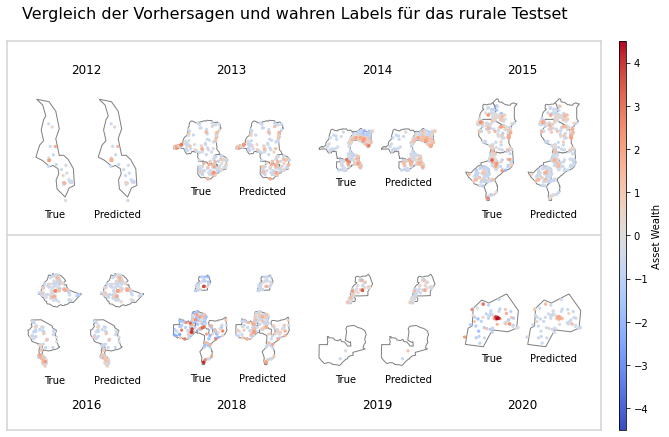

In [25]:
divnorm=colors.TwoSlopeNorm(vmin=-4.5, vcenter=0., vmax=4.5)
markersize=5
predicted_countries_gdf = countries_gdf[countries_gdf.iso_a3.isin(true_rural_wealth_df.COUNTRY_CODE)]

mosaic =  [['title_2012','title_2012','title_2012','title_2012','title_2012','title_2012','.',
            'title_2013','title_2013','title_2013','title_2013','title_2013','title_2013','.',
            'title_2014','title_2014','title_2014','title_2014','title_2014','title_2014','.',
            'title_2015','title_2015','title_2015','title_2015','title_2015','title_2015'],
        ['true2012','true2012','true2012','pred2012','pred2012','pred2012','.', 
            'true2013', 'true2013','true2013','pred2013','pred2013','pred2013', '.',
            'true2014','true2014','true2014','pred2014','pred2014','pred2014','.',
        'true2015','true2015','true2015','pred2015','pred2015','pred2015'],
           ['title_2016','title_2016','title_2016','title_2016','title_2016','title_2016','.',
            'title_2018','title_2018','title_2018','title_2018','title_2018','title_2018','.',
            'title_2019','title_2019','title_2019','title_2019','title_2019','title_2019','.',
            'title_2020','title_2020','title_2020','title_2020','title_2020','title_2020'],
           ['true2016','true2016','true2016','pred2016','pred2016','pred2016', '.', 
            'true2018','true2018','true2018', 'pred2018', 'pred2018','pred2018','.',
            'true2019','true2019','true2019','pred2019','pred2019','pred2019','.', 
            'true2020', 'true2020', 'true2020','pred2020','pred2020','pred2020'],
]
    
fig, axes = plt.subplot_mosaic(mosaic,figsize=(10,6), gridspec_kw=(dict(height_ratios=(.8,3,.8,3))))#, constrained_layout=True)
fig.suptitle('Vergleich der Vorhersagen und wahren Labels für das rurale Testset',fontsize=16)

for index, row in enumerate(mosaic):
    row = [k for k in row if k!='.']
    keys=[]
    for k in row:
        if k not in keys:
            keys.append(k)
            
    for k in keys:
        predicted_countries_gdf = countries_gdf[countries_gdf.iso_a3.isin(true_wealth_df[true_wealth_df.SURVEY_YEAR==int(k[-4:])].COUNTRY_CODE)]
        if k.startswith('title'):
            if index==0:
                axes[k].set_title(k[-4:], fontsize=12,y=0)
            else:
                axes[k].set_title(k[-4:], fontsize=12,y=-5.5)
        elif k.startswith('true'):
            predicted_countries_gdf.plot(ax=axes[k], color='white', edgecolor='grey')
            true_wealth_df[true_wealth_df.SURVEY_YEAR==int(k[-4:])].sort_values(by='WEALTH_INDEX').plot(ax = axes[k], column='WEALTH_INDEX', cmap='coolwarm',norm=divnorm, markersize=markersize)
            axes[k].set_xlabel('True')
        else:
            predicted_countries_gdf.plot(ax=axes[k], color='white', edgecolor='grey')
            predicted_wealth_df[predicted_wealth_df.SURVEY_YEAR==int(k[-4:])].sort_values(by='WEALTH_INDEX').plot(ax = axes[k], column='WEALTH_INDEX', cmap='coolwarm',norm=divnorm, markersize=markersize)
            axes[k].set_xlabel('Predicted')
        axes[k].spines['top'].set_visible(False)
        axes[k].spines['right'].set_visible(False)
        axes[k].spines['bottom'].set_visible(False)
        axes[k].spines['left'].set_visible(False)
        axes[k].get_xaxis().set_ticks([])
        axes[k].get_yaxis().set_ticks([])

line = plt.Line2D([0.1,.925],[.45,.45], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([0.1,.925],[0,0], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([0.1,.925],[.9,.9], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([0.1,0.1],[0,.9], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)
line = plt.Line2D([.925,.925],[0,.9], transform=fig.transFigure, color="lightgrey")
fig.add_artist(line)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-4.5, vmax=4.5), cmap='coolwarm')
cbaxes = fig.add_axes([0.95, 0,  0.01, 0.9])
cbar = fig.colorbar(sm, orientation='vertical',label='Asset Wealth',cax=cbaxes)

plt.show()

## Get r<sup>2</sup> Score for best Models

In [13]:
from sklearn.metrics import mean_squared_error, r2_score


urban_r2_score = r2_score(true_urban_wealth_df.WEALTH_INDEX, predicted_urban_wealth_df.WEALTH_INDEX)
rural_r2_score = r2_score(true_rural_wealth_df.WEALTH_INDEX, predicted_rural_wealth_df.WEALTH_INDEX)

print(urban_r2_score)
rural_r2_score

0.32608796277450536


0.14404635936378374

## Save Predictions and Groundtruth

In [26]:
predicted_urban_wealth_df.to_csv('./predicted_urban_wealth_df.csv')
true_urban_wealth_df.to_csv('./true_urban_wealth_df.csv')

predicted_rural_wealth_df.to_csv('./predicted_rural_wealth_df.csv')
true_rural_wealth_df.to_csv('./true_rural_wealth_df.csv')

In [6]:
predicted_urban_wealth_df = pd.read_csv('./predicted_urban_wealth_df.csv')[['SURVEY_YEAR','geometry', 'WEALTH_INDEX']]
predicted_urban_wealth_df = gpd.GeoDataFrame(predicted_urban_wealth_df.loc[:, [c for c in predicted_urban_wealth_df.columns if c != "geometry"]],
                                             geometry=gpd.GeoSeries.from_wkt(predicted_urban_wealth_df["geometry"]),
                                             crs=crs,
                                            )

true_urban_wealth_df = pd.read_csv('./true_urban_wealth_df.csv')[['SURVEY_YEAR','geometry','COUNTRY_CODE', 'WEALTH_INDEX']]
true_urban_wealth_df = gpd.GeoDataFrame(true_urban_wealth_df.loc[:, [c for c in true_urban_wealth_df.columns if c != "geometry"]],
                                        geometry=gpd.GeoSeries.from_wkt(true_urban_wealth_df["geometry"]),
                                        crs=crs,
                                       )


predicted_rural_wealth_df = pd.read_csv('./predicted_rural_wealth_df.csv')[['SURVEY_YEAR','geometry', 'WEALTH_INDEX']]
predicted_rural_wealth_df = gpd.GeoDataFrame(predicted_rural_wealth_df.loc[:, [c for c in predicted_rural_wealth_df.columns if c != "geometry"]],
                                             geometry=gpd.GeoSeries.from_wkt(predicted_rural_wealth_df["geometry"]),
                                             crs=crs,
                                            )

true_rural_wealth_df = pd.read_csv('./true_rural_wealth_df.csv')[['SURVEY_YEAR','geometry','COUNTRY_CODE', 'WEALTH_INDEX']]
true_rural_wealth_df = gpd.GeoDataFrame(true_rural_wealth_df.loc[:, [c for c in true_rural_wealth_df.columns if c != "geometry"]],
                                        geometry=gpd.GeoSeries.from_wkt(true_rural_wealth_df["geometry"]),
                                        crs=crs,
                                       )


# Predict Asset Wealth for Mozambique

## Load general geographic Data of Mozambique 

In [28]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
moz = world[world.name=='Mozambique']

## Load Mozambique Survey Data

In [29]:
moz_df = pd.read_csv('./moz_2016_2021.csv')
moz_df = moz_df[['URBAN_RURA', 'LATNUM', 'LONGNUM', 'SURVEY_YEAR', 'Filename']]
print(moz_df.shape)
moz_df.head(3)

(2635, 5)


,URBAN_RURA,LATNUM,LONGNUM,SURVEY_YEAR,Filename
0,0,-13.2856,35.2311,2016,-13.2856_35.2311_20160101-20161231_MOZ_u_2.0.tif
1,0,-13.3226,35.2552,2016,-13.3226_35.2552_20160101-20161231_MOZ_u_2.0.tif
2,0,-13.2716,35.1965,2016,-13.2716_35.1965_20160101-20161231_MOZ_u_2.0.tif



## Urban
### Load Data for Mozambique 2016, 2017, 2019, 2020 and 2021

In [30]:
model = keras.models.load_model('./vgg19_viirs_s2_u.h5')

In [31]:
moz_path_urban = '/mnt/datadisk/data/VIIRS_Sentinel2/asset/urban/mozambique_2016_2021'
moz_list_urban = os.listdir(moz_path_urban)
len(moz_list_urban)

1115

In [32]:
moz_2016_urban = [i for i in moz_list_urban if '2016' in i]
moz_2017_urban = [i for i in moz_list_urban if '2017' in i]
moz_2019_urban = [i for i in moz_list_urban if '2019' in i]
moz_2020_urban = [i for i in moz_list_urban if '2020' in i]
moz_2021_urban = [i for i in moz_list_urban if '2021' in i]

In [33]:
data_urban = {}
for moz_data_urban in [[moz_2016_urban,'2016'],[moz_2017_urban,'2017'],[moz_2019_urban,'2019'],[moz_2020_urban,'2020'],[moz_2021_urban,'2021']]:
    data_urban[moz_data_urban[1]] = np.zeros(shape=(len(moz_data_urban[0]), 14, 200, 200))
    for index, img in tqdm(enumerate(moz_data_urban[0])):
        # Read in each Image
        with rasterio.open(os.path.join(moz_path_urban, img)) as i:
            array = i.read().astype("float32")

        # Ensure that the Array is not empty
        array[np.isnan(array)] = 0
        assert not np.any(np.isnan(array)), "Float"

        data_urban[moz_data_urban[1]][index] = array

    data_urban[moz_data_urban[1]] = data_urban[moz_data_urban[1]].transpose(0, 2, 3, 1)
    assert len(data_urban[moz_data_urban[1]]) == len(moz_data_urban[0])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Predict Asset Wealth

In [34]:
preds_urban = {}
for year in tqdm(data_urban.keys()):
    preds_urban[year] = model.predict(data_urban[year])
print(preds_urban.keys())
len(preds_urban['2016'])

  0%|          | 0/5 [00:00<?, ?it/s]

dict_keys(['2016', '2017', '2019', '2020', '2021'])


223

In [35]:
pred_file_urban_dict = {'Filename':moz_2016_urban+moz_2017_urban+moz_2019_urban+moz_2020_urban+moz_2021_urban, 
                 'Prediction':[pred[0] for pred in preds_urban['2016']]+
                 [pred[0] for pred in preds_urban['2017']]+
                 [pred[0] for pred in preds_urban['2019']]+
                 [pred[0] for pred in preds_urban['2020']]+
                 [pred[0] for pred in preds_urban['2021']]}
pred_file_urban_df = pd.DataFrame(pred_file_urban_dict)
print(pred_file_urban_df.shape)
pred_file_urban_df.head(3)

(1115, 2)


,Filename,Prediction
0,-25.9443_32.6146_20160101-20161231_MOZ_u_2.0.tif,1.961596
1,-25.9002_32.6141_20160101-20161231_MOZ_u_2.0.tif,1.722382
2,-23.7538_35.3463_20160101-20161231_MOZ_u_2.0.tif,1.993611


### Merge Predictions with Survey Data

In [36]:
asset_pred_urban_df = moz_df.merge(pred_file_urban_df)
print(asset_pred_urban_df.shape)
asset_pred_urban_df.head(3)

(1115, 6)


,URBAN_RURA,LATNUM,LONGNUM,SURVEY_YEAR,Filename,Prediction
0,0,-13.2856,35.2311,2016,-13.2856_35.2311_20160101-20161231_MOZ_u_2.0.tif,1.521431
1,0,-13.3226,35.2552,2016,-13.3226_35.2552_20160101-20161231_MOZ_u_2.0.tif,1.153307
2,0,-13.2716,35.1965,2016,-13.2716_35.1965_20160101-20161231_MOZ_u_2.0.tif,1.414657


### Merge Predictions with Survey Data

In [37]:
geometry = gpd.points_from_xy(asset_pred_urban_df.LONGNUM, asset_pred_urban_df.LATNUM)

In [38]:
asset_pred_urban_df = gpd.GeoDataFrame(asset_pred_urban_df,
                       geometry=geometry,
                       crs=crs
                      )
asset_pred_urban_df = asset_pred_urban_df[['SURVEY_YEAR', 'geometry', 'Prediction']]
print(asset_pred_urban_df.shape)
asset_pred_urban_df.head(3)

(1115, 3)


,SURVEY_YEAR,geometry,Prediction
0,2016,POINT (35.23110 -13.28560),1.521431
1,2016,POINT (35.25520 -13.32260),1.153307
2,2016,POINT (35.19650 -13.27160),1.414657


In [39]:
urban_2016_df = asset_pred_urban_df[asset_pred_urban_df.SURVEY_YEAR==2016]
urban_2016_df.shape

urban_2017_df = asset_pred_urban_df[asset_pred_urban_df.SURVEY_YEAR==2017]
urban_2017_df.shape

urban_2019_df = asset_pred_urban_df[asset_pred_urban_df.SURVEY_YEAR==2019]
urban_2019_df.shape

urban_2020_df = asset_pred_urban_df[asset_pred_urban_df.SURVEY_YEAR==2020]
urban_2020_df.shape

urban_2021_df = asset_pred_urban_df[asset_pred_urban_df.SURVEY_YEAR==2021]
urban_2021_df.shape

(223, 3)

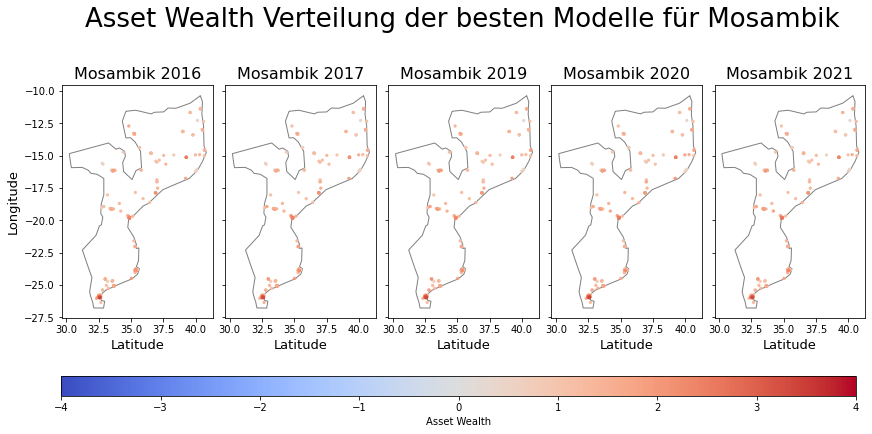

In [40]:
fig, axes = plt.subplots(1, 5, sharey=True,constrained_layout=True, figsize=(12,9))


from matplotlib import colors

divnorm=colors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
markersize=5
subplot_title_size = 16

axes[0].set_aspect('equal')
plt.suptitle('Asset Wealth Verteilung der besten Modelle für Mosambik', fontsize=26, y=.8, x=0.53)

moz.plot(ax=axes[0], color='white', edgecolor='grey')

urban_2016_df.sort_values(by='Prediction').plot(ax = axes[0], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)


axes[0].set_xlabel('Latitude', fontsize=13)
axes[0].set_ylabel('Longitude', fontsize=13)
axes[0].set_title('Mosambik 2016', fontsize=subplot_title_size)
axes[0].set_aspect('equal')

moz.plot(ax=axes[1], color='white', edgecolor='grey')
urban_2017_df.sort_values(by='Prediction').plot(ax = axes[1], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)


axes[1].set_xlabel('Latitude', fontsize=13)
axes[1].set_title('Mosambik 2017', fontsize=subplot_title_size)

axes[1].set_aspect('equal')

moz.plot(ax=axes[2], color='white', edgecolor='grey')
urban_2019_df.sort_values(by='Prediction').plot(ax = axes[2], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
axes[2].set_xlabel('Latitude', fontsize=13)
axes[2].set_title('Mosambik 2019', fontsize=subplot_title_size)
axes[2].set_aspect('equal')

moz.plot(ax=axes[3], color='white', edgecolor='grey')
urban_2020_df.sort_values(by='Prediction').plot(ax = axes[3], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
axes[3].set_xlabel('Latitude', fontsize=13)
axes[3].set_title('Mosambik 2020', fontsize=subplot_title_size)
axes[3].set_aspect('equal')

moz.plot(ax=axes[4], color='white', edgecolor='grey')
urban_2021_df.sort_values(by='Prediction').plot(ax = axes[4], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
axes[4].set_xlabel('Latitude', fontsize=13)
axes[4].set_title('Mosambik 2021', fontsize=subplot_title_size)
axes[4].set_aspect('equal')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-4, vmax=4), cmap='coolwarm')
cbaxes = fig.add_axes([0.066, 0.2, .92, 0.03])
cbar = fig.colorbar(sm, orientation='horizontal',label='Asset Wealth',cax=cbaxes)


plt.show()

## Rural
### Load Data for Mozambique 2016, 2017, 2019, 2020 and 2021

In [41]:
model = keras.models.load_model('./resnet50_r_viirs.h5')

In [42]:
moz_path_rural = '/mnt/datadisk/data/VIIRS/preprocessed/asset/rural/mozambique_2016_2021/prep'

moz_rural = os.listdir(moz_path_rural)
len(moz_rural)

1520

In [43]:
moz_2016_rural = [i for i in moz_rural if '2016' in i]
moz_2017_rural = [i for i in moz_rural if '2017' in i]
moz_2019_rural = [i for i in moz_rural if '2019' in i]
moz_2020_rural = [i for i in moz_rural if '2020' in i]
moz_2021_rural = [i for i in moz_rural if '2021' in i]

In [44]:
data_rural= {}
for moz_data_rural in [[moz_2016_rural,'2016'],[moz_2017_rural,'2017'],[moz_2019_rural,'2019'],[moz_2020_rural,'2020'],[moz_2021_rural,'2021']]:
    data_rural[moz_data_rural[1]] = np.zeros(shape=(len(moz_data_rural[0]), 3, 1000, 1000))
    for index, img in tqdm(enumerate(moz_data_rural[0])):
        # Read in each Image
        with rasterio.open(os.path.join(moz_path_rural, img)) as i:
            array = i.read().astype("float32")

        # Ensure that the Array is not empty
        array[np.isnan(array)] = 0
        assert not np.any(np.isnan(array)), "Float"

        # Add to batch
        data_rural[moz_data_rural[1]][index] = array

        # Check if batch is already full (Note: Index in batch array is from 0...4 hence we need to add +1 to batch_ele)
    data_rural[moz_data_rural[1]] = data_rural[moz_data_rural[1]].transpose(0, 2, 3, 1)
    assert len(data_rural[moz_data_rural[1]]) == len(moz_data_rural[0])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Predict Asset Wealth

In [45]:
from tensorflow.keras import optimizers, models
preds_rural = {}
for year in tqdm(data_rural.keys()):
    preds_rural[year] = model.predict(data_rural[year])
print(preds_rural.keys())
len(preds_rural['2016'])

  0%|          | 0/5 [00:00<?, ?it/s]

dict_keys(['2016', '2017', '2019', '2020', '2021'])


304

In [46]:
pred_rural_file_dict = {'Filename':
                        moz_2016_rural+
                        moz_2017_rural+
                        moz_2019_rural+
                        moz_2020_rural+
                        moz_2021_rural, 
                        'Prediction':
                        [pred[0] for pred in preds_rural['2016']]+
                        [pred[0] for pred in preds_rural['2017']]+
                        [pred[0] for pred in preds_rural['2019']]+
                        [pred[0] for pred in preds_rural['2020']]+
                        [pred[0] for pred in preds_rural['2021']]}
pred_rural_file_df = pd.DataFrame(pred_rural_file_dict)
print(pred_rural_file_df.shape)
pred_rural_file_df.head(3)

(1520, 2)


,Filename,Prediction
0,-20.5253_34.0313_20160101-20161231_MOZ_r_10.0.tif,-0.588530
1,-14.4227_38.3001_20160101-20161231_MOZ_r_10.0.tif,-0.469308
2,-15.8257_38.5071_20160101-20161231_MOZ_r_10.0.tif,-0.588530


### Merge Predictions with Survey Data

In [47]:
asset_pred_rural_df = moz_df.merge(pred_rural_file_df)
print(asset_pred_rural_df.shape)
asset_pred_rural_df.head(3)

(1520, 6)


,URBAN_RURA,LATNUM,LONGNUM,SURVEY_YEAR,Filename,Prediction
0,1,-15.1365,36.5967,2016,-15.1365_36.5967_20160101-20161231_MOZ_r_10.0.tif,-0.266213
1,1,-14.6769,36.4565,2016,-14.6769_36.4565_20160101-20161231_MOZ_r_10.0.tif,-0.588530
2,1,-12.0948,34.8491,2016,-12.0948_34.8491_20160101-20161231_MOZ_r_10.0.tif,-0.588530


### Get Geocoordinates and create Geometry Objects

### Merge Predictions with Survey Data

In [48]:
geometry = gpd.points_from_xy(asset_pred_rural_df.LONGNUM, asset_pred_rural_df.LATNUM)

In [49]:
asset_pred_rural_df = gpd.GeoDataFrame(asset_pred_rural_df,
                       geometry=geometry,
                       crs=crs
                      )
asset_pred_rural_df = asset_pred_rural_df[['SURVEY_YEAR', 'geometry', 'Prediction']]
print(asset_pred_rural_df.shape)
asset_pred_rural_df.head(3)

(1520, 3)


,SURVEY_YEAR,geometry,Prediction
0,2016,POINT (36.59670 -15.13650),-0.266213
1,2016,POINT (36.45650 -14.67690),-0.588530
2,2016,POINT (34.84910 -12.09480),-0.588530


In [50]:
asset_pred_rural_df.to_csv('./moz_rural_asset_wealth_prediction.csv')

In [51]:
rural_2016_df = asset_pred_rural_df[asset_pred_rural_df.SURVEY_YEAR==2016]
rural_2016_df.shape

rural_2017_df = asset_pred_rural_df[asset_pred_rural_df.SURVEY_YEAR==2017]
rural_2017_df.shape

rural_2019_df = asset_pred_rural_df[asset_pred_rural_df.SURVEY_YEAR==2019]
rural_2019_df.shape

rural_2020_df = asset_pred_rural_df[asset_pred_rural_df.SURVEY_YEAR==2020]
rural_2020_df.shape

rural_2021_df = asset_pred_rural_df[asset_pred_rural_df.SURVEY_YEAR==2021]
rural_2021_df.shape

(304, 3)

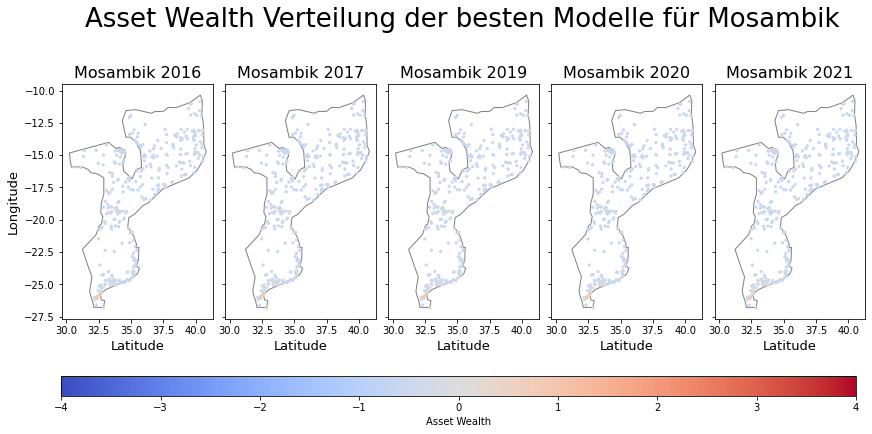

In [52]:
fig, axes = plt.subplots(1, 5, sharey=True,constrained_layout=True, figsize=(12,9))


from matplotlib import colors

divnorm=colors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
markersize=5
subplot_title_size = 16

axes[0].set_aspect('equal')
plt.suptitle('Asset Wealth Verteilung der besten Modelle für Mosambik', fontsize=26, y=.8, x=0.53)

moz.plot(ax=axes[0], color='white', edgecolor='grey')
rural_2016_df.sort_values(by='Prediction').plot(ax = axes[0], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)

axes[0].set_xlabel('Latitude', fontsize=13)
axes[0].set_ylabel('Longitude', fontsize=13)
axes[0].set_title('Mosambik 2016', fontsize=subplot_title_size)
axes[0].set_aspect('equal')

moz.plot(ax=axes[1], color='white', edgecolor='grey')
rural_2017_df.sort_values(by='Prediction').plot(ax = axes[1], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
axes[1].set_xlabel('Latitude', fontsize=13)
axes[1].set_title('Mosambik 2017', fontsize=subplot_title_size)

axes[1].set_aspect('equal')

moz.plot(ax=axes[2], color='white', edgecolor='grey')
rural_2019_df.sort_values(by='Prediction').plot(ax = axes[2], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
axes[2].set_xlabel('Latitude', fontsize=13)
axes[2].set_title('Mosambik 2019', fontsize=subplot_title_size)
axes[2].set_aspect('equal')

moz.plot(ax=axes[3], color='white', edgecolor='grey')
rural_2020_df.sort_values(by='Prediction').plot(ax = axes[3], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
axes[3].set_xlabel('Latitude', fontsize=13)
axes[3].set_title('Mosambik 2020', fontsize=subplot_title_size)
axes[3].set_aspect('equal')

moz.plot(ax=axes[4], color='white', edgecolor='grey')
rural_2021_df.sort_values(by='Prediction').plot(ax = axes[4], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
axes[4].set_xlabel('Latitude', fontsize=13)
axes[4].set_title('Mosambik 2021', fontsize=subplot_title_size)
axes[4].set_aspect('equal')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-4, vmax=4), cmap='coolwarm')
cbaxes = fig.add_axes([0.066, 0.2, .92, 0.03])
cbar = fig.colorbar(sm, orientation='horizontal',label='Asset Wealth',cax=cbaxes)


plt.show()

## Plot Predictions

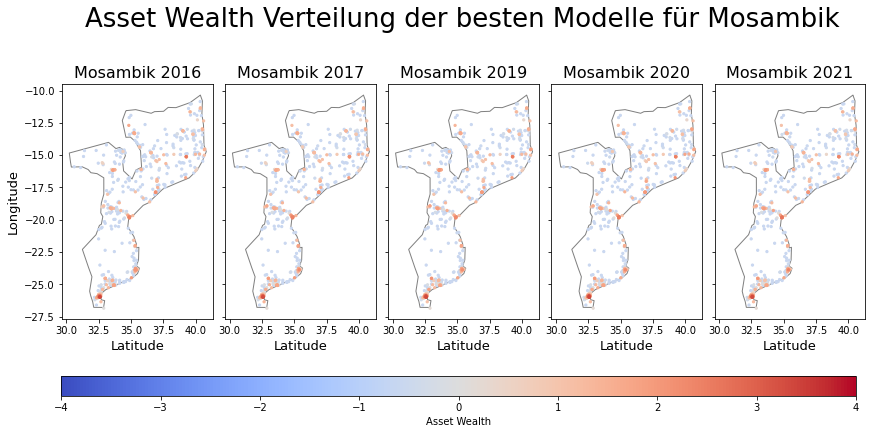

In [53]:
fig, axes = plt.subplots(1, 5, sharey=True,constrained_layout=True, figsize=(12,9))


from matplotlib import colors

divnorm=colors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
markersize=5
subplot_title_size = 16

axes[0].set_aspect('equal')
plt.suptitle('Asset Wealth Verteilung der besten Modelle für Mosambik', fontsize=26, y=.8, x=0.53)

moz.plot(ax=axes[0], color='white', edgecolor='grey')
rural_2016_df.sort_values(by='Prediction').plot(ax = axes[0], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)

urban_2016_df.sort_values(by='Prediction').plot(ax = axes[0], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)


axes[0].set_xlabel('Latitude', fontsize=13)
axes[0].set_ylabel('Longitude', fontsize=13)
axes[0].set_title('Mosambik 2016', fontsize=subplot_title_size)
axes[0].set_aspect('equal')

moz.plot(ax=axes[1], color='white', edgecolor='grey')
rural_2017_df.sort_values(by='Prediction').plot(ax = axes[1], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
urban_2017_df.sort_values(by='Prediction').plot(ax = axes[1], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)


axes[1].set_xlabel('Latitude', fontsize=13)
axes[1].set_title('Mosambik 2017', fontsize=subplot_title_size)

axes[1].set_aspect('equal')

moz.plot(ax=axes[2], color='white', edgecolor='grey')
rural_2019_df.sort_values(by='Prediction').plot(ax = axes[2], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
urban_2019_df.sort_values(by='Prediction').plot(ax = axes[2], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
axes[2].set_xlabel('Latitude', fontsize=13)
axes[2].set_title('Mosambik 2019', fontsize=subplot_title_size)
axes[2].set_aspect('equal')

moz.plot(ax=axes[3], color='white', edgecolor='grey')
rural_2020_df.sort_values(by='Prediction').plot(ax = axes[3], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
urban_2020_df.sort_values(by='Prediction').plot(ax = axes[3], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
axes[3].set_xlabel('Latitude', fontsize=13)
axes[3].set_title('Mosambik 2020', fontsize=subplot_title_size)
axes[3].set_aspect('equal')

moz.plot(ax=axes[4], color='white', edgecolor='grey')
rural_2021_df.sort_values(by='Prediction').plot(ax = axes[4], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
urban_2021_df.sort_values(by='Prediction').plot(ax = axes[4], column='Prediction', 
                 cmap='coolwarm', norm=divnorm, markersize=markersize)
axes[4].set_xlabel('Latitude', fontsize=13)
axes[4].set_title('Mosambik 2021', fontsize=subplot_title_size)
axes[4].set_aspect('equal')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-4, vmax=4), cmap='coolwarm')
cbaxes = fig.add_axes([0.066, 0.2, .92, 0.03])
cbar = fig.colorbar(sm, orientation='horizontal',label='Asset Wealth',cax=cbaxes)


plt.show()

In [54]:
data = {'urban': {'2016': urban_2016_df, 
                  '2017': urban_2017_df,
                  '2019': urban_2019_df, 
                  '2020': urban_2020_df, 
                  '2021': urban_2021_df},
        
        'rural': {'2016': rural_2016_df, 
                  '2017': rural_2017_df, 
                  '2019': rural_2019_df, 
                  '2020': rural_2020_df, 
                  '2021': rural_2021_df}
       }
statistics = []
for ur, ur_data in data.items():
    for year, pred in ur_data.items():
        statistics.append([ur,
                           year,
                           round(pred.Prediction.min(),2),
                           round(pred.Prediction.max(),2),
                           round(pred.Prediction.mean(),2),
                           round(pred.Prediction.median(),2),
                           round(pred.Prediction.var(),2),
                           round(pred.Prediction.skew(),2),
                           round(pred.Prediction.kurtosis(),2)])
pred_statistics_df = pd.DataFrame(data=statistics, columns=['Urban/Rural','Jahr','Min','Max', 'Arithmetisches\nMittel','Median','Varianz','Schiefe','Kurtosis'])
pred_statistics_df

['urban', '2016', 0.32, 3.38, 1.53, 1.45, 0.32, 0.57, 0.7]
['urban', '2017', 0.32, 3.3, 1.55, 1.51, 0.32, 0.47, 0.48]
['urban', '2019', 0.33, 3.36, 1.57, 1.52, 0.3, 0.61, 0.88]
['urban', '2020', 0.35, 3.4, 1.59, 1.53, 0.34, 0.58, 0.55]
['urban', '2021', 0.33, 3.32, 1.57, 1.53, 0.34, 0.53, 0.47]
['rural', '2016', -0.62, 1.02, -0.52, -0.59, 0.04, 4.61, 25.61]
['rural', '2017', -0.63, 1.02, -0.51, -0.59, 0.05, 4.16, 20.34]
['rural', '2019', -0.62, 1.05, -0.51, -0.59, 0.05, 4.47, 23.02]
['rural', '2020', -0.67, 0.96, -0.51, -0.59, 0.05, 4.23, 20.31]
['rural', '2021', -0.59, 0.81, -0.5, -0.59, 0.05, 3.66, 14.73]


,Urban/Rural,Jahr,Min,Max,Arithmetisches\nMittel,Median,Varianz,Schiefe,Kurtosis
0,urban,2016,0.32,3.38,1.53,1.45,0.32,0.57,0.700000
1,urban,2017,0.32,3.30,1.55,1.51,0.32,0.47,0.480000
2,urban,2019,0.33,3.36,1.57,1.52,0.30,0.61,0.880000
3,urban,2020,0.35,3.40,1.59,1.53,0.34,0.58,0.550000
4,urban,2021,0.33,3.32,1.57,1.53,0.34,0.53,0.470000
5,rural,2016,-0.62,1.02,-0.52,-0.59,0.04,4.61,25.610001
6,rural,2017,-0.63,1.02,-0.51,-0.59,0.05,4.16,20.340000
7,rural,2019,-0.62,1.05,-0.51,-0.59,0.05,4.47,23.020000
8,rural,2020,-0.67,0.96,-0.51,-0.59,0.05,4.23,20.309999
9,rural,2021,-0.59,0.81,-0.50,-0.59,0.05,3.66,14.730000
